<a href="https://colab.research.google.com/github/Gheras13/Homework/blob/main/Homework_1_2R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MACHINE LEARNING HOMEWORK 1

#DIRECT KINEMATICS OF ROBOT MANIPLUATOR

In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# GENERAZIONE DEI DATI

In [4]:

file_path = '/content/drive/My Drive/File_csv/Copia di r2_20_100k.csv'
dataset = pd.read_csv(file_path, sep=';', header=0)

# Rimozioni di spazi dai nomi delle colonne
dataset.columns = dataset.columns.str.strip()
df = dataset.iloc[:30000]
# Estrazione feature (j0, j1) e i target (ee_x, ee_y)
X = df[['j0', 'j1']].values  # Angoli articolari
Y = df[['ee_x', 'ee_y']].values  # Posizioni finali (end-effector)


In [5]:
# Divisione dei dati in training e testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


#BASE_MODEL, DROPOUT, WEIGHT_DECAY

Rete neurale FeedForward con tensorflow

Definisce una rete neurale feedforward in cui i layer sono collegati uno dopo l'altro (architettura sequenziale).
Ogni layer prende in input l'output del layer precedente.

Definizione di una rete neurale feedforward per la cinematica diretta.
 Struttura:
Struttura:
-Due strati nascosti con un numero configurabile di neuroni (hidden_neurons), attivazione ReLU e opzioni di regolarizzazione (Dropout e L2).

-Uno strato di output con due neuroni per generare le coordinate.

-SOLVER Adam, LOSS FUNCTION MSE e metrica MAE.


In [6]:
def build_model(hidden_neurons, learning_rate, dropout_rate=None, l2_lambda=None):
    layers = [
        tf.keras.layers.Dense(
            hidden_neurons, activation='relu', input_shape=(2,),
            kernel_regularizer=tf.keras.regularizers.l2(l2_lambda) if l2_lambda else None
        )
    ]

    if dropout_rate:
        layers.append(tf.keras.layers.Dropout(dropout_rate))  # Aggiunta Dropout

    layers.extend([
        tf.keras.layers.Dense(
            hidden_neurons, activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(l2_lambda) if l2_lambda else None
        ),
        tf.keras.layers.Dense(2)
    ])

    model = tf.keras.Sequential(layers)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )
    return model


#GRID SEARCH

In [7]:
from itertools import product

# Parametri per il tuning del modello base
hidden_layers = [64, 128]
learning_rates = [0.01, 0.001]

results = []

print("Tuning sul modello base...")
for hl, lr in product(hidden_layers, learning_rates):
    print(f"Test sul modello {hl} hidden neurons e {lr} learning rate")
    model_baseline = build_model(hidden_neurons=hl, learning_rate=lr)
    history = model_baseline.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=32, verbose=0)
    loss, mae = model_baseline.evaluate(X_test, Y_test, verbose=0)
    results.append((hl, lr, loss, mae))

# Migliori risultati
sorted_results = sorted(results, key=lambda x: x[2])
best_config = sorted_results[0]
print(f"Miglior configurazione trovata per il modello base: Neuroni Nascosti={best_config[0]}, Learning Rate={best_config[1]}")


Tuning sul modello base...
Testing Baseline Model with 64 hidden neurons and 0.01 learning rate


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Testing Baseline Model with 64 hidden neurons and 0.001 learning rate


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Testing Baseline Model with 128 hidden neurons and 0.01 learning rate
Testing Baseline Model with 128 hidden neurons and 0.001 learning rate
Miglior configurazione trovata per il modello base: Neuroni Nascosti=128, Learning Rate=0.001


#COMPILAZIONE DEL MODELLO

In [8]:
# Parametri ottimali trovati dal tuning
optimal_hidden_neurons = best_config[0]
optimal_learning_rate = best_config[1]

# Configurazioni per Dropout e Weight Decay
dropout_rate = 0.2
l2_lambda = 0.001
import time

# Lista per i risultati finali
final_results = []

# 1. Modello Base
print("\nAddestramento Modello Base...")
start_time = time.time()
model_baseline = build_model(hidden_neurons=optimal_hidden_neurons, learning_rate=optimal_learning_rate)
history_baseline = model_baseline.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=32, verbose=0)
end_time = time.time()
loss, mae = model_baseline.evaluate(X_test, Y_test, verbose=0)
training_time = end_time - start_time
final_results.append(('Baseline', loss, mae, training_time))
print(f"Tempo di allenamento Modello Base: {training_time:.2f} secondi")

# 2. Modello con Dropout
print("\nAddestramento Modello con Dropout...")
start_time = time.time()
model_dropout = build_model(hidden_neurons=optimal_hidden_neurons, learning_rate=optimal_learning_rate, dropout_rate=dropout_rate)
history_dropout = model_dropout.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=32, verbose=0)
end_time = time.time()
loss, mae = model_dropout.evaluate(X_test, Y_test, verbose=0)
training_time = end_time - start_time
final_results.append(('Dropout', loss, mae, training_time))
print(f"Tempo di allenamento Modello con Dropout: {training_time:.2f} secondi")

# 3. Modello con Weight Decay
print("\nAddestramento Modello con Weight Decay...")
start_time = time.time()
model_l2 = build_model(hidden_neurons=optimal_hidden_neurons, learning_rate=optimal_learning_rate, l2_lambda=l2_lambda)
history_l2 = model_l2.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=32, verbose=0)
end_time = time.time()
loss, mae = model_l2.evaluate(X_test, Y_test, verbose=0)
training_time = end_time - start_time
final_results.append(('Weight Decay', loss, mae, training_time))
print(f"Tempo di allenamento Modello con Weight Decay: {training_time:.2f} secondi")

# Stampa dei risultati finali
print("\nConfronto Finale tra i Modelli:")
for res in final_results:
    print(f"Modello: {res[0]}, Loss: {res[1]:.4f}, MAE: {res[2]:.4f}, Tempo di Allenamento: {res[3]:.2f} secondi")



Addestramento Modello Base...
Tempo di allenamento Modello Base: 40.51 secondi

Addestramento Modello con Dropout...
Tempo di allenamento Modello con Dropout: 39.45 secondi

Addestramento Modello con Weight Decay...
Tempo di allenamento Modello con Weight Decay: 49.08 secondi

Confronto Finale tra i Modelli:
Modello: Baseline, Loss: 0.0000, MAE: 0.0036, Tempo di Allenamento: 40.51 secondi
Modello: Dropout, Loss: 0.0001, MAE: 0.0068, Tempo di Allenamento: 39.45 secondi
Modello: Weight Decay, Loss: 0.0003, MAE: 0.0057, Tempo di Allenamento: 49.08 secondi


#PLOT DEI RISULTATI


Confronto Finale tra i Modelli:
Modello: Baseline, Loss: 0.0000, MAE: 0.0036
Modello: Dropout, Loss: 0.0001, MAE: 0.0068
Modello: Weight Decay, Loss: 0.0003, MAE: 0.0057


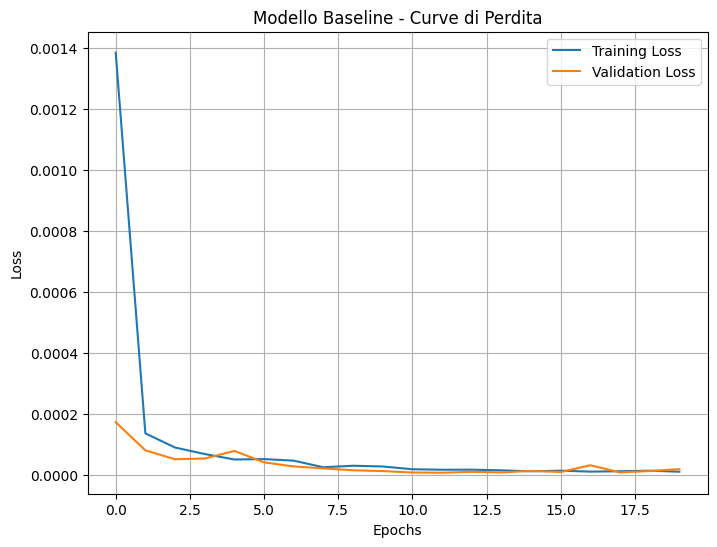

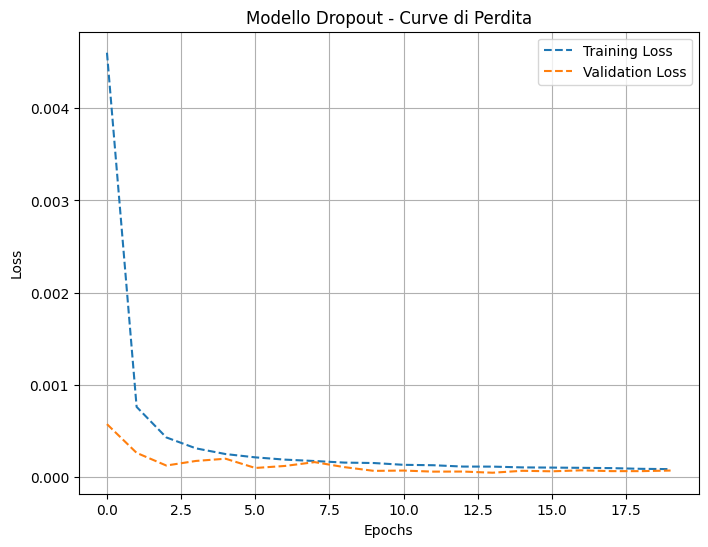

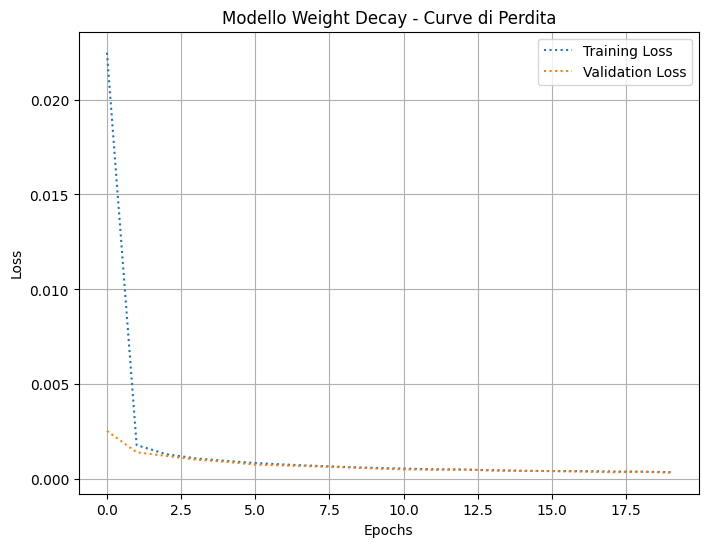

In [9]:

print("\nConfronto Finale tra i Modelli:")
for res in final_results:
    print(f"Modello: {res[0]}, Loss: {res[1]:.4f}, MAE: {res[2]:.4f}")

# Grafico per il Modello Base
plt.figure(figsize=(8, 6))
plt.plot(history_baseline.history['loss'], label='Training Loss')
plt.plot(history_baseline.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Modello Baseline - Curve di Perdita')
plt.legend()
plt.grid(True)
plt.show()

# Grafico per il Modello Dropout
plt.figure(figsize=(8, 6))
plt.plot(history_dropout.history['loss'], label='Training Loss', linestyle='dashed')
plt.plot(history_dropout.history['val_loss'], label='Validation Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Modello Dropout - Curve di Perdita')
plt.legend()
plt.grid(True)
plt.show()

# Grafico per il Modello Weight Decay
plt.figure(figsize=(8, 6))
plt.plot(history_l2.history['loss'], label='Training Loss', linestyle='dotted')
plt.plot(history_l2.history['val_loss'], label='Validation Loss', linestyle='dotted')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Modello Weight Decay - Curve di Perdita')
plt.legend()
plt.grid(True)
plt.show()


#JACOBIAN

In [10]:
@tf.function
def FK_Jacobian(model, x):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        y = FK(model, x)
    return tape.jacobian(y, x)

def FK(model, theta):
    t = tf.reshape(theta, shape=(1, 2))
    out = model(t)
    out = tf.reshape(out, shape=(2,))
    return out

def analytical_J(theta, L1=0.1, L2=0.1):
    j0, j1 = theta
    J = np.array([
        [-L1 * np.sin(j0) - L2 * np.sin(j0 + j1), -L2 * np.sin(j0 + j1)],
        [L1 * np.cos(j0) + L2 * np.cos(j0 + j1),  L2 * np.cos(j0 + j1)]
    ])
    return J


In [11]:

models = {
    "Baseline": model_baseline,
    "Dropout": model_dropout,
    "Weight Decay": model_l2
}

# Parametri del robot
L1, L2 =  0.1, 0.1  # Lunghezze dei link

# Campione di test
theta_sample = X_test[0]  # Primo esempio di test

# Confronto dei modelli
for model_name, model in models.items():
    print(f"\nConfronto per il modello: {model_name}")

    # Calcolo della Jacobiana appresa
    jacobian_learned = FK_Jacobian(model, tf.convert_to_tensor([theta_sample], dtype=tf.float32))

    # Calcolo della Jacobiana analitica
    jacobian_analytical = analytical_J(theta_sample, L1, L2)

    # Flatten delle matrici
    jacobian_learned_flat = jacobian_learned.numpy().flatten()
    jacobian_analytical_flat = jacobian_analytical.flatten()

    # Calcolo del MSE
    mse = np.mean((jacobian_learned_flat - jacobian_analytical_flat) ** 2)


    # Visualizza le Jacobiane
    print("\nJacobiana appresa:\n", jacobian_learned.numpy())
    print("\nJacobiana analitica:\n", jacobian_analytical)
    print("\nMean Squared Error (MSE): ",mse)


Confronto per il modello: Baseline

Jacobiana appresa:
 [[[-0.15408668 -0.09775449]]

 [[-0.05886935  0.02829725]]]

Jacobiana analitica:
 [[-0.14902079 -0.09704286]
 [-0.06129121  0.02413884]]

Mean Squared Error (MSE):  1.2331836524021291e-05

Confronto per il modello: Dropout

Jacobiana appresa:
 [[[-0.17851433 -0.11681731]]

 [[-0.0402567   0.03732746]]]

Jacobiana analitica:
 [[-0.14902079 -0.09704286]
 [-0.06129121  0.02413884]]

Mean Squared Error (MSE):  0.0004693219958745738

Confronto per il modello: Weight Decay

Jacobiana appresa:
 [[[-0.14835696 -0.11350228]]

 [[-0.09462432 -0.00287092]]]

Jacobiana analitica:
 [[-0.14902079 -0.09704286]
 [-0.06129121  0.02413884]]

Mean Squared Error (MSE):  0.0005279941628242274
